# KNN classifier

This shows how the set up was for one of the classifiers: kNN. First, you will see a classifier with a preprocessing of PCA. After this, we discovered that there was just too much variance in the outcome. Since tuning the kNN parameters did not give the more robust results we were searching for, we took a step back to the preprocessing. The choice was made to use the univariate feature selection. This, because it might give way to less features being selected and therefore hopefully a more robust result, or higher AUC. 

In [1]:
# Import packages

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from hn.load_data import load_data

from sklearn import decomposition
from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, decomposition, svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [2]:
# Preprocessing function of PCA

def data_preprocessing_pca(X_train, X_validation):
    ''' Data preprocessing: first scaling and then PCA with a optimized number of components '''

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Principle component analysis
    # Using the cumulative summation of the explained variance, we concluded that in
    # order to retain 95% of the variance 30 components are needed.

    pca = PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca

In [3]:
# Preprocessing function of Univariate Analysis 

def data_preprocessing_uni(X_train, y_train, X_validation):
    '''Data preprocessing: first scaling and then univariate analysis'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)

    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  # Naming the dataframe columns
    best_features = featureScores.nlargest(10,'Score')['Specs']

    X_train_uni = df_X_train_scaled[best_features]
    X_validation_uni = df_X_validation_scaled[best_features]

    return X_train_uni, X_validation_uni

In [8]:
# Loading of the data 

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = preprocessing.label_binarize(y_labels, ['T12', 'T34']) 
# 0 stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

# Split data in a train and test set
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y, stratify=y, test_size=0.2)

The number of samples: 113
The number of features: 159


First, the example below will show the search for the proper kNN parameter of the amount of nearest neighbours. 

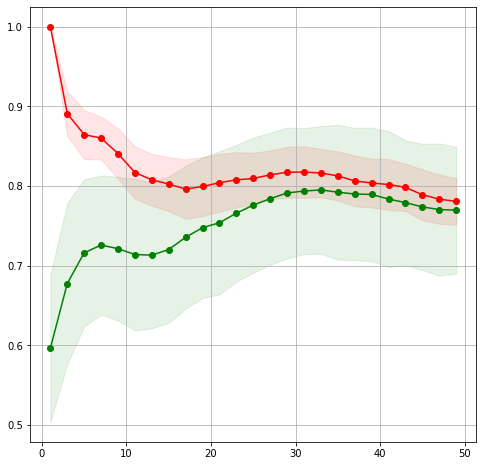

In [10]:
# kNN
# Preprocessing: PCA
# Applied on the training-validation data
# AUROC of different values for K in kNN

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)

k_list = list(range(1, 50, 2))
all_train = []
all_validation = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        validation_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

        for k in k_list:
            clf_knn = KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
            validation_proba = clf_knn.predict_proba(X_validation_pca)[:, 1]
            
            score_train = metrics.roc_auc_score(y_train, train_proba)
            score_validation = metrics.roc_auc_score(y_validation, validation_proba)

            train_scores.append(score_train)
            validation_scores.append(score_validation)

        all_train.append(train_scores)
        all_validation.append(validation_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_validation = np.array(all_validation)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

validation_scores_mean = all_validation.mean(axis=0)
validation_scores_std = all_validation.std(axis=0)

# Plot the learning curves (mean scores and the std as shading)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, validation_scores_mean, 'o-', color="g",
        label="Validation score")

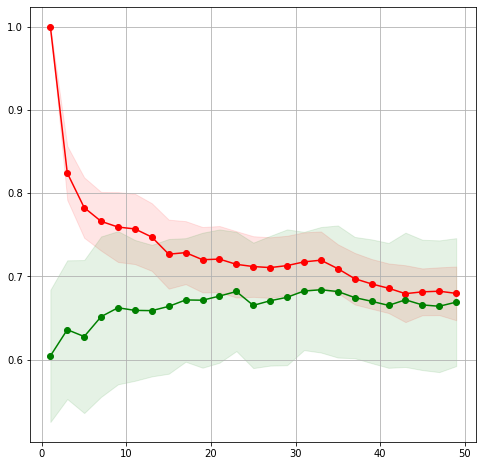

In [26]:
# kNN
# Preprocessing: PCA
# Applied on the training-validation data
# Now, the kNN will be plotted for the scoring of the classifiers. 

k_list = list(range(1, 50, 2))
all_train = []
all_validation = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        validation_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

        for k in k_list:
            clf_knn = KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            score_train = clf_knn.score(X_train_pca, y_train)
            score_validation = clf_knn.score(X_validation_pca, y_validation)            

            train_scores.append(score_train)
            validation_scores.append(score_validation)

        all_train.append(train_scores)
        all_validation.append(validation_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_validation = np.array(all_validation)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

validation_scores_mean = all_validation.mean(axis=0)
validation_scores_std = all_validation.std(axis=0)

# Plot the learning curves (mean scores and the std as shading)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, validation_scores_mean, 'o-', color="g",
        label="Validation score")

The above graphics show the trend of the kNN, another method for obtaining the exact kNN that works best in a certain fold is through a GridSearch. This is done below. 

In [12]:
# kNN
# Preprocessing: PCA
# GridSearchCV to determine k 
# Applied on the training-validation data

clf_knn = KNeighborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {"n_neighbors": list(range(1, 50, 2))}

cv_5fold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_5fold, scoring='roc_auc')

result = []
for _ in range(20):
    # Preprocessing 
    X_train_pca, X_validation_pca = data_preprocessing_pca(split_X_train, X_validation)
    grid_search.fit(X_train_pca, split_y_train)
    print(grid_search.best_params_)

{'n_neighbors': 31}
{'n_neighbors': 29}
{'n_neighbors': 33}
{'n_neighbors': 33}
{'n_neighbors': 31}
{'n_neighbors': 27}
{'n_neighbors': 41}
{'n_neighbors': 37}
{'n_neighbors': 45}
{'n_neighbors': 29}
{'n_neighbors': 33}
{'n_neighbors': 33}
{'n_neighbors': 27}
{'n_neighbors': 41}
{'n_neighbors': 29}
{'n_neighbors': 37}
{'n_neighbors': 25}
{'n_neighbors': 27}
{'n_neighbors': 31}
{'n_neighbors': 17}


There is quite some variance in the best kNN number.

In [13]:
# kNN
# Preprocessing: PCA
# GridSearchCV to determine k 
# Applied on the test data

clf_knn = KNeighborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {"n_neighbors": list(range(1, 50, 2))}

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')

train_all = []
test_all = []

for _ in range(10):
    for train_index, test_index in cv_4fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_pca, X_test_pca = data_preprocessing_pca(X_train, X_test)
        grid_search.fit(X_train_pca, y_train) 
        clf_knn = grid_search.best_estimator_

        # Tests 
        train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
        test_proba = clf_knn.predict_proba(X_test_pca)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)


        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(test_scores_mean)
print(test_scores_std)

[0.73290816]
[0.06837544]


This gives quite okay results if we want to achieve an AUC of 70%, however the standard deviation varies quite a lot. In addition to the already varying AUC. Therefore, we have to get back to our strategy. The hyperparameter is, partly, already tuned. Another big influence on the result is the way in which preprocessing was done. Therefore, we will now explore another method; Univariate. For the breviation, only the validation-train curve using AUROC is visualized in the below example. Hereafter, the direct hyperparameter tuning with GridSearchCV is used in the 'inner' loop and compared to the test set. 

# Univariate Analysis 

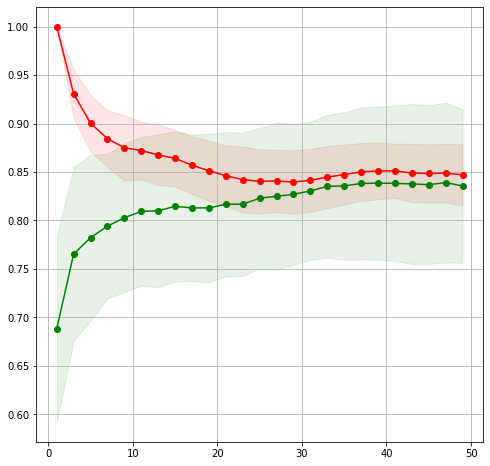

In [21]:
# kNN
# Preprocessing: Univariate Analysis 
# Applied on the training-validation set
# AUROC of different values for K in kNN, on the validation-training set. 

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)

k_list = list(range(1, 50, 2))
all_train = []
all_test = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_uni, X_validation_uni = data_preprocessing_uni(X_train, y_train, X_validation)

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_uni, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_uni)[:, 1]
            test_proba = clf_knn.predict_proba(X_validation_uni)[:, 1]
            
            score_train = metrics.roc_auc_score(y_train, train_proba)
            score_test = metrics.roc_auc_score(y_validation, test_proba)

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the learning curves (mean scores and the std as shading)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")

It shows a higher AUROC already in the graph, with a standard deviation above the 0.70. Now, lets have a look on how it performs on our test set with the hyperparameters chosen in the 'inner' loop.  

In [24]:
# kNN Univariate Analy: is with GridSearch 
# ermine k aCVpplied on the te
# At set

clf_knn = KNdatahborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {"n_neighbors": list(range(1, 50, 2))}

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')

train_all = []
test_all = []
for _ in range(4):
    for train_index, test_index in cv_4fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_uni, X_test_uni = data_preprocessing_uni(X_train, y_train, X_test)

        grid_search.fit(X_train_uni, y_train) 
        clf_knn = grid_search.best_estimator_

        # Tests 
        train_proba = clf_knn.predict_proba(X_train_uni)[:, 1]
        test_proba = clf_knn.predict_proba(X_test_uni)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)

        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(test_scores_mean)
print(test_scores_std)

[0.82844388]
[0.05022903]
